# Figure 2

Radar, lidar, and microwave radiometer observations during a 550 km southbound transect over sea ice on 14 March 2022.

In [1]:
from string import ascii_lowercase

import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from lizard.ac3airlib import segment_times
from lizard.mpltools import style
from lizard.mpltools.legend import fancy_legend
from lizard.readers.band_pass import read_band_pass
from lizard.readers.gps_ins import read_gps_ins
from lizard.readers.halo_kt19 import read_halo_kt19
from lizard.readers.hamp import read_hamp
from lizard.readers.mira import read_mira
from lizard.readers.wales import read_wales
from lizard.writers.figure_to_file import write_figure

In [2]:
ds_bp = read_band_pass("HAMP")

In [3]:
flight_id = "HALO-AC3_HALO_RF04"
segment_id = "HALO-AC3_HALO_RF04_hl08"
t0, t1 = segment_times(segment_id)

In [4]:
ds_mira = read_mira(flight_id)
ds_wales = read_wales(flight_id, product="bsrgl")
ds_hamp = read_hamp(flight_id)
ds_gps = read_gps_ins(flight_id)
ds_kt19 = read_halo_kt19(flight_id)

/work/nrisse/miniconda3/envs/py311/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [5]:
print(ds_gps.alt.sel(time=slice(t0, t1)).mean("time").item() * 1e-3)

11.689007309105424


Created figure file: /home/nrisse/phd/projects/sea_ice_clouds/plots/paper/fig02.png


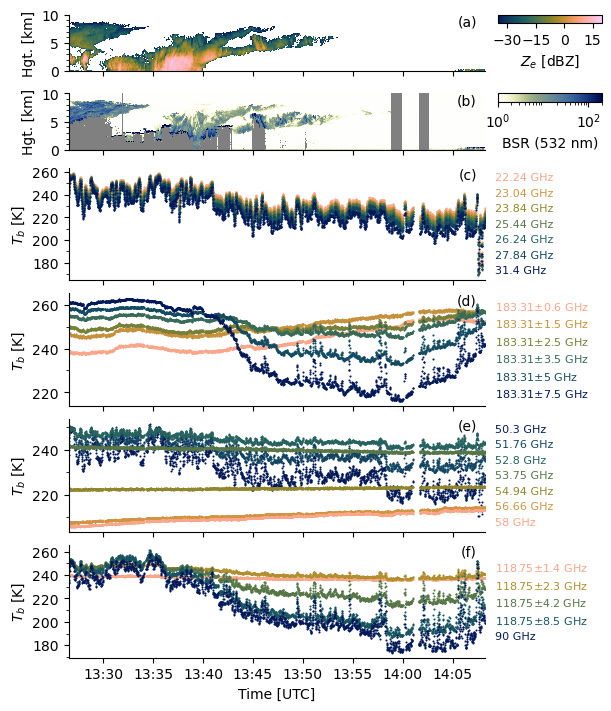

In [6]:
fig, axes = plt.subplot_mosaic(
    [
        ["radar"],
        ["wales"],
        ["tb1"],
        ["tb2"],
        ["tb3"],
        ["tb4"],
    ],
    sharex=True,
    figsize=(6, 7),
    layout="constrained",
    height_ratios=[1, 1, 2, 2, 2, 2],
)

for i, ax in enumerate(axes.values()):
    ax.annotate(
        f"({ascii_lowercase[i]})",
        xy=(0.98, 1),
        xycoords="axes fraction",
        ha="right",
        va="top",
    )

# radar
im_ze = axes["radar"].pcolormesh(
    ds_mira["time"].sel(time=slice(t0, t1)),
    ds_mira["height"] * 1e-3,
    ds_mira["dBZg"].sel(time=slice(t0, t1)).T,
    cmap=cmc.batlow,
    shading="nearest",
    vmin=-35,
    vmax=20,
)
axes["radar"].set_ylabel("Hgt. [km]")

# wales lidar
cmap = cmc.davos_r.copy()
cmap.set_bad("gray")
norm = mcolors.LogNorm(1, 200)
im_bsr = axes["wales"].pcolormesh(
    ds_wales["time"].sel(time=slice(t0, t1)),
    ds_wales["altitude"] * 1e-3,
    ds_wales["backscatter_ratio"]
    .where(ds_wales["flags"] == 0)
    .sel(time=slice(t0, t1))
    .T,
    cmap=cmap,
    shading="nearest",
    norm=norm,
)
axes["wales"].set_ylabel("Hgt. [km]")

for ax in [axes["radar"], axes["wales"]]:
    ax.set_ylim(0, 10)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))


# hamp tb
hamp_bands = {
    "22.24 GHz (H$_2$O)": [1, 2, 3, 4, 5, 6, 7],
    "183.31 GHz (H$_2$O)": [20, 21, 22, 23, 24, 25],
    "50-60 GHz (O$_2$)": [8, 9, 10, 11, 12, 13, 14],
    "118.75 GHz (O$_2$), 90 GHz": [16, 17, 18, 19, 15],
}

axes_hamp = [axes["tb1"], axes["tb2"], axes["tb3"], axes["tb4"]]

for i_band, band in enumerate(list(hamp_bands.keys())):
    axes_hamp[i_band].set_ylabel("$T_b$ [K]")

    axes_hamp[i_band].yaxis.set_major_locator(mticker.MultipleLocator(20))
    axes_hamp[i_band].yaxis.set_minor_locator(mticker.MultipleLocator(10))

    for i_channel, channel in enumerate(hamp_bands[band]):
        cmap = cmc.batlow_r(np.linspace(0.2, 1, len(hamp_bands[band])))

        if i_band == 2:
            cmap = cmap[::-1]

        if channel not in ds_hamp["tb"].channel.values:
            continue

        axes_hamp[i_band].plot(
            ds_hamp["time"].sel(time=slice(t0, t1)),
            ds_hamp["tb"].sel(time=slice(t0, t1), channel=channel),
            color=cmap[i_channel],
            label=ds_bp.label.sel(channel=channel).item(),
            marker=".",
            linewidth=0,
            markersize=3,
            markeredgewidth=0,
        )

    leg = fancy_legend(
        axes_hamp[i_band],
        legend_params=dict(
            bbox_to_anchor=(1, 0.5), loc="center left", fontsize=8
        ),
    )
    leg.set_in_layout(True)

axes["tb4"].set_xlabel("Time [UTC]")
axes["tb4"].set_xlim(t0, t1)
axes["tb4"].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.draw()
cax = axes["radar"].inset_axes([1.03, 0.85, 0.25, 0.15])
fig.colorbar(
    im_ze,
    cax=cax,
    label="$Z_e$ [dBZ]",
    ticks=[-30, -15, 0, 15],
    orientation="horizontal",
)

cax = axes["wales"].inset_axes([1.03, 0.85, 0.25, 0.15])
fig.colorbar(
    im_bsr,
    cax=cax,
    label="BSR (532 nm)",
    ticks=[1, 100],
    orientation="horizontal",
)

write_figure(
    fig,
    f"paper/fig02.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()